# Mixture of Gaussians

In this note, we will solve the mixture of Gaussians

This block contains some $\LaTeX$ macros.
$\newcommand{\E}{\mathbb{E}}$
$\renewcommand{\Re}{\mathbb{R}}$
$\newcommand{\oft}[1]{{^{(#1)}}}$
$\newcommand{\oftt}[2]{{^{(#1)#2}}}$

In [1]:
import util
from util import *
import numpy as np
import models
import mompy as mp
import cvxopt

np.set_printoptions(precision=3, suppress=True)
from IPython.display import display, Markdown, Math
from operator import mul
import sympy as sp

sp.init_printing()

## Noiseless Example

Let's construct a toy example for the rest of this document.

Let $\xi_1, ..., \xi_K \in \Re^D$ be the set of means. Let $c_1, ..., c_K \in \Re^D$ be the set of diagonal covariances.

In [2]:
k = 6
d = 6
degobs = 3
degmm = 2

sc.random.seed(101)
gm = models.GaussianMixtureModel.generate('', k, d, means='hypercube', cov='spherical_uniform')

constraints = gm.polymom_all_constraints(degobs)
xis = gm.sym_means
covs = gm.sym_covs
sym_all = xis + covs
print 'The polynomial constraints are as follows'
display(constraints)

The polynomial constraints are as follows


With this machinery, we can compute the moment polynomials required for the moment method magic!

In [3]:
MM = mp.MomentMatrix(degmm, sym_all, morder='grevlex')
display(MM.row_monos)

In [4]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints)
solsdp = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  1.4228e+00  1.4228e+00  2e+02  1e+01  1e+00  1e+00
 1:  5.8448e-01  1.4981e+00  1e+01  1e+00  2e-01  1e+00
 2:  1.9520e+00  2.7409e+00  2e+01  1e+00  2e-01  9e-01
 3:  2.6681e+00  2.7968e+00  2e+00  2e-01  3e-02  1e-01
 4:  2.9312e+00  2.9500e+00  8e-01  8e-02  1e-02  3e-02
 5:  2.9878e+00  2.9910e+00  2e-01  2e-02  3e-03  5e-03
 6:  2.9973e+00  2.9982e+00  8e-02  8e-03  1e-03  2e-03
 7:  3.0007e+00  3.0008e+00  1e-02  1e-03  2e-04  2e-04
 8:  3.0010e+00  3.0011e+00  1e-03  1e-04  2e-05  2e-05
 9:  3.0011e+00  3.0011e+00  2e-04  2e-05  2e-06  3e-06
10:  3.0011e+00  3.0011e+00  8e-06  7e-07  1e-07  1e-07
11:  3.0011e+00  3.0011e+00  9e-07  8e-08  1e-08  1e-08
Optimal solution found.


In [5]:
sol_lasserre = mp.extractors.extract_solutions_lasserre(MM, solsdp['x'], Kmax = k)
sol_dreesen = mp.extractors.extract_solutions_dreesen(MM, solsdp['x'], Kmax = k)
trueparams = {}

for i in xrange(d):
    trueparams[xis[i]] = []
    trueparams[covs[i]] = []
    for j in xrange(k):
        trueparams[xis[i]].append(gm.means[i,j])
        trueparams[covs[i]].append(gm.sigmas[j,i,i])
print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre)
print 'recovered parameters (Dreesen)'
display(sol_dreesen)

the biggest singular value we are losing is 0.000000
the next biggest eigenvalue we are losing is 0.000000
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)


{c1: [array([ 0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01+0.j])],
 c2: [array([ 0.01+0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j])],
 c6: [array([ 0.01+0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j])],
 xi4: [array([-0.043+0.j   , -0.180-0.595j, -0.180+0.595j,  0.855+1.522j,
          0.855-1.522j,  0.433+0.j   ])],
 xi6: [array([ 0.437+0.j   ,  0.152+0.472j,  0.152-0.472j,  0.040-0.313j,
          0.040+0.313j,  0.341+0.j   ])],
 xi3: [array([ 0.060+0.j   ,  0.522+0.431j,  0.522-0.431j, -0.086-0.357j,
         -0.086+0.357j,  0.153+0.j   ])],
 c3: [array([ 0.01+0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j])],
 c5: [array([ 0.01+0.j,  0.01+0.j,  0.01-0.j,  0.01-0.j,  0.01+0.j,  0.01+0.j])],
 xi2: [array([ 0.407+0.j   ,  0.101+0.168j,  0.101-0.168j, -0.060+0.132j,
         -0.060-0.132j, -0.134+0.j   ])],
 c4: [array([ 0.01+0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j,  0.01-0.j,  0.01+0.j])],
 xi1: [array([-0.089+0.j   , -0.124-0.318j, 

## Now take samples!


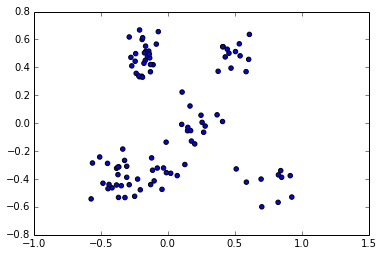

In [6]:
num_samples = 100
X = gm.sample(num_samples)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy.linalg

# plot after a random orthogonal projection
randdir,__,__ = np.linalg.svd(np.random.randn(d,2))
Y = X.dot(randdir[:,0:2])
plt.scatter(Y[:,0], Y[:,1]);

constraints_noisy = gm.polymom_all_constraints_samples(3, X)
display(constraints_noisy)

In [7]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints_noisy)
solsdp_noisy = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  1.4136e+00  1.4136e+00  2e+02  1e+01  1e+00  1e+00
 1:  5.8221e-01  1.4954e+00  1e+01  1e+00  2e-01  1e+00
 2:  1.9479e+00  2.7261e+00  2e+01  1e+00  2e-01  9e-01
 3:  2.6354e+00  2.7628e+00  2e+00  2e-01  3e-02  1e-01
 4:  2.8892e+00  2.9111e+00  9e-01  9e-02  1e-02  3e-02
 5:  2.9509e+00  2.9545e+00  2e-01  2e-02  3e-03  5e-03
 6:  2.9619e+00  2.9631e+00  9e-02  9e-03  1e-03  2e-03
 7:  2.9672e+00  2.9675e+00  2e-02  2e-03  2e-04  4e-04
 8:  2.9687e+00  2.9687e+00  1e-02  1e-03  1e-04  2e-04
 9:  2.9694e+00  2.9695e+00  2e-03  2e-04  3e-05  3e-05
10:  2.9697e+00  2.9697e+00  4e-04  3e-05  5e-06  5e-06
11:  2.9698e+00  2.9698e+00  5e-05  4e-06  6e-07  6e-07
12:  2.9698e+00  2.9698e+00  5e-06  4e-07  6e-08  5e-08
13:  2.9698e+00  2.9698e+00  2e-07  2e-08  3e-09  3e-09
Optimal solution found.


In [8]:
sol_lasserre_noisy = mp.extractors.extract_solutions_lasserre(MM, solsdp_noisy['x'], Kmax = k)
sol_dreesen_noisy = mp.extractors.extract_solutions_dreesen_proto(MM, solsdp_noisy['x'], Kmax = k)

print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre_noisy)
print 'recovered parameters (Dreesen)'
display(sol_dreesen_noisy)

the biggest singular value we are losing is 0.007117
the next biggest eigenvalue we are losing is 0.007117
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)


## EM Algorithm

In [10]:
from algos import GaussianMixturesEM
reload(GaussianMixturesEM)
algo = GaussianMixturesEM.GaussianMixtureEM( k, d )
X.shape
lhood, Z, O_ = algo.run( X, None )

Iteration 0, lhood = 6.758004
Iteration 1, lhood = 7.118180
Iteration 2, lhood = 7.443712
Iteration 3, lhood = 7.989042
Iteration 4, lhood = 7.989052
Iteration 5, lhood = 7.989052
Iteration 6, lhood = 7.989052
Iteration 7, lhood = 7.989052
Iteration 8, lhood = 7.989052
Iteration 9, lhood = 7.989052
Iteration 10, lhood = 7.989052
Iteration 11, lhood = 7.989052
Converged with lhood=7.989052 in 11 steps.


In [11]:
O_, gm.weights

((array([[-0.005,  0.967, -0.011,  0.005,  0.012, -0.007],
         [ 0.012,  0.024, -0.037,  0.909, -0.002,  0.001],
         [ 0.015, -0.001,  0.917,  0.01 ,  0.059,  0.023],
         [ 0.   ,  0.008, -0.004,  0.002, -0.005,  0.875],
         [ 0.003, -0.019,  0.031,  0.   ,  0.921, -0.006],
         [ 0.973, -0.026,  0.017, -0.029, -0.01 , -0.004]]),
  0.093914318988465889,
  array([ 0.208,  0.264,  0.132,  0.151,  0.104,  0.142])),
 array([ 0.275,  0.156,  0.169,  0.15 ,  0.096,  0.155]))

In [12]:
gm.sigmas

array([[[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01]],

       [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01]],

       [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01]],

       [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
      

In [13]:
k, d, M, S, w = gm.k, gm.d, gm.means, gm.sigmas, gm.weights
import algos.GaussianMixturesSpectral as gms
M_ = gms.find_means(X, k)
print "M_", M_.T


M3 [[[ 0.274  0.009  0.001  0.002 -0.005 -0.009]
  [ 0.009  0.001  0.    -0.001  0.002 -0.002]
  [ 0.001  0.    -0.001 -0.    -0.     0.   ]
  [ 0.002 -0.001 -0.    -0.001 -0.    -0.   ]
  [-0.005  0.002 -0.    -0.     0.001 -0.   ]
  [-0.009 -0.002  0.    -0.    -0.    -0.001]]

 [[ 0.009  0.001  0.    -0.001  0.002 -0.002]
  [ 0.001  0.138  0.002 -0.001 -0.001 -0.004]
  [ 0.     0.002 -0.005 -0.     0.    -0.001]
  [-0.001 -0.001 -0.     0.001  0.     0.001]
  [ 0.002 -0.001  0.     0.    -0.001 -0.001]
  [-0.002 -0.004 -0.001  0.001 -0.001  0.004]]

 [[ 0.001  0.    -0.001 -0.    -0.     0.   ]
  [ 0.     0.002 -0.005 -0.     0.    -0.001]
  [-0.001 -0.005  0.125 -0.     0.004  0.003]
  [-0.    -0.    -0.     0.003 -0.    -0.   ]
  [-0.     0.     0.004 -0.     0.008 -0.   ]
  [ 0.    -0.001  0.003 -0.    -0.     0.004]]

 [[ 0.002 -0.001 -0.    -0.001 -0.    -0.   ]
  [-0.001 -0.001 -0.     0.001  0.     0.001]
  [-0.    -0.    -0.     0.003 -0.    -0.   ]
  [-0.001  0.001  0.003  